# Финальный проект: «Модель прогнозирования стоимости жилья для агентства недвижимости»

Цель проекта — разработать моделья прогнозирования стоимости недвижимости.

In [1]:
#импорт библиотек:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn import linear_model 
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import ensemble 
import re
from sklearn.model_selection import GridSearchCV
from scipy.stats import shapiro
from sklearn import tree
from sklearn.pipeline import Pipeline
import pickle

In [120]:
#загрузка датасета
data = pd.read_csv('data.csv')

## 1. Обработка и очистка данных, разведывательный анализ

>разведывательный анализ начну сразу проводить в этом пункте

In [3]:
#посмотрим на количество строк и столбцов
data.shape

(377185, 18)

In [4]:
#посмотрим на количество пропусков в процентном соотношении
data.isnull().sum()/data.shape[0]*100

status          10.583136
private pool    98.891525
propertyType     9.208479
street           0.000530
baths           28.192532
homeFacts        0.000000
fireplace       72.661956
city             0.009014
schools          0.000000
sqft            10.757851
zipcode          0.000000
beds            24.200856
state            0.000000
stories         39.957846
mls-id          93.387330
PrivatePool     89.312672
MlsId           17.731352
target           0.657767
dtype: float64

### 1.1 Признаки fireplace, private pool, PrivatePool, mls-id

In [50]:
#посмотрим на значения признака fireplace:
data.fireplace.value_counts().head(29)

yes                          50356
Yes                          20856
1                            14544
2                             2432
Not Applicable                1993
Fireplace                      847
3                              564
Living Room                    433
LOCATION                       399
Wood Burning                   311
Gas/Gas Logs                   300
No                             289
Fireplace YN                   287
Special Features               279
1 Fireplace                    274
0                              271
FAMILYRM                       246
Fireplace Features             239
Great Room                     207
Wood                           206
Gas Logs, Great Room           188
Ceiling Fan                    186
Living Room, Wood Burning      185
4                              184
Family Room, Wood Burning      149
FAMILYRM, Gas Logs             146
Gas                            134
Gas Logs, In Great Room        112
Gas Logs            

In [51]:
#количество пропусков признака
len(data.fireplace) - data.fireplace.isnull().sum()

103115

>в признаке  fireplace имеется 103115 значения (остальные пропуски), что составляет всего 27% данных.  БОльшая часть этих ненулевых значений говорит о наличии камина (описаны различные типы камина). То есть либо данные остутствуют,  либо камин есть. Очень малая часть данных говорит об отсутствии камина. Считаю этот признак неинформативным, поэтому его лучше исключить.

> за наличие бассейна отвечает два признака: private pool и PrivatePool и в обоих пропусков около 90% - удаляем оба признака. Также удалим признак mls-id (пропусков более 90%):

In [121]:
data = data.drop(['private pool', 'PrivatePool', 'mls-id', 'fireplace'], axis=1)

### 1.2 Обработка признака status

In [122]:
#приведем все символы к нижнему регистру
data['status'] = data['status'].str.lower()

In [123]:
#сгруппируем похожие статусы в отдельные списки
foclosure_list = ['foreclosure', 'foreclosed']
pre_foclosure_list = ['pre-foreclosure', 'pre-foreclosure / auction']
under_contract_accept_list = ['under contract', 'active under contract', 'under contract   showing', 'under contract show']
under_contract_not_accept_list = ['under contract backups', 'active backup', 'backup contract']
auction_list = ['active auction', 'auction active', 'auction', ' / auction']

In [124]:
#объединим похожие статусы
data['status'] = data['status'].apply(lambda x: 'foreclosure' if x in foclosure_list else x)
data['status'] = data['status'].apply(lambda x: 'pre_foclosure' if x in pre_foclosure_list else x)
data['status'] = data['status'].apply(lambda x: 'accepted_contract' if x in under_contract_accept_list else x)
data['status'] = data['status'].apply(lambda x: 'not_accepted_contract' if x in under_contract_not_accept_list else x)
data['status'] = data['status'].apply(lambda x: 'auction' if x in auction_list else x)
data['status'] = data['status'].apply(lambda x: 'active' if x=='a active' else x)


In [125]:
#оставим первые 13 статусов, возможно, впоследствии некоторые объединим, остальные пометим как other
top_status = data.status.value_counts(normalize=True).nlargest(13).index.to_list()
data['status'] = data['status'].apply(lambda x: 'other' if x not in top_status and x is not np.nan else x)

In [546]:
data.status.value_counts().head(29)

for sale             199571
active               105650
foreclosure            7228
new construction       5475
pending                4807
pre_foclosure          3679
accepted_contract      3386
other                  2279
p                      1488
auction                1472
new                     690
contingent              581
price change            563
for rent                398
Name: status, dtype: int64

### 1.3. обработка признака propertyType

In [547]:
data['propertyType'].nunique()

1280

In [126]:
#приведем все символы к нижнему регистру
data['propertyType'] = data['propertyType'].str.lower()

In [127]:
#объединим похожие типы собственности
data['propertyType'] = data['propertyType'].apply(lambda x: 'single_family' if (x=='single-family home' or x=='single family' or x=='single family home' 
                                                                                or x=='single detached, traditional' or x=='detached, one story' or x=='one story'
                                                                                or x=='single detached' or x=='1 story' or x=='1 story, traditional' or x=='singlefamilyresidence'
                                                                                or x=='single detached, contemporary/modern') else x )
data['propertyType'] = data['propertyType'].apply(lambda x: 'multi_family' if (x=='multi family' or x=='multi-family' or x=='multi-family home' or x=='multiple occupancy') else x )
data['propertyType'] = data['propertyType'].apply(lambda x: 'mobile' if (x=='mobile' or x=='manufactured home (house)' or x=='prefab' 
                                                                         or x=='modular' or x=='mo2 le' or x=='mo2le' or x=='mobile / manufactured'
                                                                         or x=='mobile/manufactured' or x=='mfd/mobile home') else x )
data['propertyType'] = data['propertyType'].apply(lambda x: 'double_family' if (x=='detached, two story' or x=='two story' or x=='2 story' or x=='2 stories, traditional' or x=='2 stories' or x=='2 stories, contemporary') else x )
data['propertyType'] = data['propertyType'].apply(lambda x: 'coop' if (x=='condo' or x=='condo/townhome/row home/co-op' or x=='coop' 
                                                                       or x=='cooperative' or x=='condo/townhome, traditional'
                                                                       or x=='condo/townhome' or x=='condo/townhome, contemporary/modern' or x=='condominium (single level), contemporary') else x )
data['propertyType'] = data['propertyType'].apply(lambda x: 'land' if (x=='lot/land' or x=='land') else x )
data['propertyType'] = data['propertyType'].apply(lambda x: 'modern' if (x=='contemporary' or x=='contemporary/modern' or x=='contemporary/modern, traditional') else x )
data['propertyType'] = data['propertyType'].apply(lambda x: 'modern' if (x=='traditional' or x=='traditional, transitional' or x=='urban contemporary') else x )
data['propertyType'] = data['propertyType'].apply(lambda x: 'ranch' if (x=='ranch' or x=='farms/ranches' or x=='ranch, traditional') else x )

In [128]:
#оставим первые 16 типов собственности, возможно, впоследствии некоторые объединим, остальные пометим как other
top_prop = data.propertyType.value_counts(normalize=True).nlargest(16).index.to_list()
data['propertyType'] = data['propertyType'].apply(lambda x: 'other' if x not in top_prop and x is not np.nan else x)

In [129]:
data['propertyType'].value_counts().head(16)

single_family    193209
coop              54720
land              31486
townhouse         18400
multi_family      12374
other              9231
modern             8933
mobile             3476
double_family      2551
ranch              2285
high rise          1823
colonial           1205
apartment           922
transitional        560
florida             530
bungalow            442
Name: propertyType, dtype: int64

### 1.4 Признак street

In [63]:
data['street'].nunique()

337076

>считаю, что признак street можно удалить, т.к. есть признак city и zipcode

In [130]:
data = data.drop('street', axis=1)

### 1.5 Обработка признака baths

In [131]:
data['baths'].isnull().sum()

106338

In [132]:
data['baths'].value_counts().tail(29)

10.5 Baths            1
Bathrooms: SemiMod    1
Bathrooms: 241        1
Bathrooms: 19         1
1-0 / 1-0 / 1         1
32                    1
Bathrooms: 27         1
35                    1
29 Baths              1
116 / 116 / 116       1
21 Baths              1
5.2 Baths             1
29                    1
76 Baths              1
3-1 / 2-2             1
Bathrooms: 21         1
2.25 ba               1
3.3 Baths             1
43 Baths              1
34 Baths              1
1 / 1 / 1 / 1         1
55.0                  1
25 Baths              1
0.5 Baths             1
4.75 Baths            1
5.25 Baths            1
41.0                  1
1.8 Baths             1
44.0                  1
Name: baths, dtype: int64

>переведем все символы в нижний регистр, уберем лишние слова и символы

In [133]:
data['baths'] = data['baths'].str.lower()
data['baths'] = data['baths'].str.replace('bathrooms', '')
data['baths'] = data['baths'].str.replace('baths', '')

In [134]:
data['baths'] = data['baths'].str.replace('ba', '')
data['baths'] = data['baths'].str.replace(': ', '')

In [135]:
#извлечем числовые данные из признака
data['baths_3'] = pd.to_numeric(data['baths'], errors='coerce')

In [136]:
data['baths_3'].value_counts().head(29)

2.00      101723
3.00       64996
4.00       26043
1.00       16503
2.50       12646
5.00        9223
3.50        5293
6.00        4303
0.00        3852
1.50        2099
7.00        2078
4.50        1404
8.00        1159
9.00         546
5.50         399
10.00        328
750.00       237
11.00        187
12.00        134
6.50         130
1.75          94
13.00         74
2.10          53
16.00         52
14.00         45
2.75          35
7.50          34
18.00         32
15.00         28
Name: baths_3, dtype: int64

### 1.6 Обработка признака homeFacts

#### 1.6.1 извлечем год постройки дома

In [559]:
data['homeFacts'].iloc[1]

"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '5828 sqft', 'factLabel': 'lotsize'}, {'factValue': '$159/sqft', 'factLabel': 'Price/sqft'}]}"

In [137]:
#уберем квадратные скобки
data['homeFacts'] = data['homeFacts'].str.replace('[', '')
data['homeFacts'] = data['homeFacts'].str.replace(']', '')

C:\Users\free-\AppData\Local\Temp\ipykernel_11000\2496293622.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['homeFacts'] = data['homeFacts'].str.replace('[', '')
C:\Users\free-\AppData\Local\Temp\ipykernel_11000\2496293622.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['homeFacts'] = data['homeFacts'].str.replace(']', '')


In [138]:
#скопируем датасет
df = data.copy()

In [139]:
#уберем первый ключ словаря - 'atAGlanceFacts' и фигурные скобки, относящиеся к нему
df['homeFacts'] = df['homeFacts'].apply(lambda x: x[19:])
df['homeFacts'] = df['homeFacts'].apply(lambda x: x[:-1])
#введем новый признак - year_built
df['year_built'] = df['homeFacts'].astype(str).apply(lambda x: x.split()[1])
df['year_built'] = df['year_built'].str.replace(',', '')
df['year_built'].iloc[1]

"'2019'"

In [140]:
#преобразуем признак, убрав лишние символы
df['year_built'] = df['year_built'].apply(lambda x: x[1:])
df['year_built'] = df['year_built'].apply(lambda x: x[:-1])
df['year_built'] = df['year_built'].str.replace(' ', '')
df['year_built'] = df['year_built'].str.replace('N', '')
df['year_built'] = df['year_built'].apply(lambda x: np.nan if x=='on' else x)

In [141]:
#заменим пропуски на nan
df=df.replace(r'^\s*$', np.nan, regex=True)

In [142]:
#заменим формат на числовой (float, т.к. присутствуют пропуски, на целое число их не заменить)
df['year_built'] = df['year_built'].astype('float')

#### 1.6.2.извлечем тип отопления

In [143]:
df['homeFacts'].iloc[11].split("'Remodeled year'}, {'factValue':")[1].split('factLabel')[0]

" 'Central Electric', '"

In [144]:
#произведем преобразования
df['heating_type'] = df['homeFacts'].apply(lambda x: x.split("'Remodeled year'}, {'factValue':")[1].split('factLabel')[0])
df['heating_type'] = df['heating_type'].apply(lambda x: x[1:])
df['heating_type'] = df['heating_type'].apply(lambda x: x[:-3])
df['heating_type'] = df['heating_type'].str.replace('"''"', '')
df['heating_type']=df['heating_type'].str.lower()
df['heating_type'] = df['heating_type'].apply(lambda x: x[1:])
df['heating_type'] = df['heating_type'].apply(lambda x: x[:-1])
df['heating_type'].iloc[2]

'forced air'

In [145]:
#объединим похожие или одинаковые типы
forced_air_list=['forced air, heat pump', 'forced air', 'forced air heating', 'forced air, stove', 'forced air, other', 'forced air, stove']
central_list = ['central, electric, two or more units', 'central, electric, zoned', 'central air', 'central electric', 'central', 'central, electric', 'central air, ceiling fan(s)', 'central furnace', 'central electric, zoned', 'central heating', 'central air, central heat', 'central electric, heat pump', 'central, electric, heat pump', 'central, electric, heat pump', 'central, heat pump' ]
gas_list = ['gas', 'natural gas heat', 'forced air, gas', ', gas hot air/furnace', 'gas heat', 'forced air, natural gas', 'natural gas']
electric_list=['electric', 'electric heat' ]
heat_pump_list = ['heat pump', ', heat pump - heat', 'heat pump(s)']
refrigeration_list = ['refrigeration', 'refrigeration, ceiling fan(s)']
df['heating_type'] = df['heating_type'].apply(lambda x: 'forced_air' if x in forced_air_list else x)
df['heating_type'] = df['heating_type'].apply(lambda x: 'gas' if x in gas_list else x)
df['heating_type'] = df['heating_type'].apply(lambda x: 'central' if x in central_list else x)
df['heating_type'] = df['heating_type'].apply(lambda x: 'electric' if x in electric_list else x)
df['heating_type'] = df['heating_type'].apply(lambda x: 'heat_pump' if x in heat_pump_list else x)
df['heating_type'] = df['heating_type'].apply(lambda x: 'refrigeration' if x in refrigeration_list else x)

In [146]:
#заменим значения 'on' (оно образовалось от None) и 'no data' на пропуски
df['heating_type'] = df['heating_type'].apply(lambda x: np.nan if x=='on' or x=='no data' else x)

In [147]:
#заменим отсутствующие данные на пропуски
df=df.replace(r'^\s*$', np.nan, regex=True)

In [148]:
#оставим первые 6 типов, остальные пометим как other
top_heating = df.heating_type.value_counts(normalize=True).nlargest(6).index.to_list()
df['heating_type'] = df['heating_type'].apply(lambda x: 'other' if x not in top_heating and x is not np.nan else x)

In [149]:
df['heating_type'].value_counts(normalize=True)

forced_air    0.530092
other         0.208381
central       0.119043
gas           0.054463
electric      0.051230
heat_pump     0.036792
Name: heating_type, dtype: float64

#### 1.6.3 извлечем тип парковки из признака homeFacts

In [150]:
#уберем лишние символы
df['parking'] = df['homeFacts'].apply(lambda x: x.split("'Cooling'}, {'factValue':")[1].split('factLabel')[0])
df['parking'] = df['parking'].apply(lambda x: x[2:])
df['parking'] = df['parking'].apply(lambda x: x[:-4])
df['parking'] = df['parking'].str.lower()
df['parking'].iloc[2]

'attached garage'

In [151]:
#объединим похожие или одинаковые типы
two_spaces_list=['2 spaces', '2', 'garage - 2 car', 'attached garage, garage - 2 car']
three_spaces_list=['3 spaces', '3']
one_space_list=['1 space', '1']
four_spaces_list=['4 spaces', '4']
six_spaces_list=['6 spaces', '6']
off_street_list=['off street', 'off street parking']
no_parking_list=['on street', '0', 'driveway']
attached_garage_list=['attached garage, off street', 'attached - front', 'attached', 'attached - side', 'garage-attached', 'attached garage', 'carport, attached garage', 'attached garage, carport', 'off street, attached garage', 'carport, attached garage' ]
attached_detached_garage_list=['attached garage, detached garage', 'detached garage, attached garage']
detached_garage_list=['off street, detached garage', 'detached garage', 'carport, detached garage', 'detached garage, carport']

df['parking'] = df['parking'].apply(lambda x: 'two_spaces' if x in two_spaces_list else x)
df['parking'] = df['parking'].apply(lambda x: 'three_spaces' if x in three_spaces_list else x)
df['parking'] = df['parking'].apply(lambda x: 'one_space' if x in one_space_list else x)
df['parking'] = df['parking'].apply(lambda x: 'four_spaces' if x in four_spaces_list else x)
df['parking'] = df['parking'].apply(lambda x: 'off_street' if x in off_street_list else x)
df['parking'] = df['parking'].apply(lambda x: 'no_parking' if x in no_parking_list else x)
df['parking'] = df['parking'].apply(lambda x: 'attached_garage' if x in attached_garage_list else x)
df['parking'] = df['parking'].apply(lambda x: 'attached_detached_garage' if x in attached_detached_garage_list else x)
df['parking'] = df['parking'].apply(lambda x: 'detached_garage' if x in detached_garage_list else x)
df['parking'] = df['parking'].apply(lambda x: 'six_spaces' if x in six_spaces_list else x)

In [152]:
#заменим некоторые фразы на пропуски
df['parking'] = df['parking'].apply(lambda x: np.nan if x=='on' or x=='no data' or x=='none' else x)

In [153]:
#заменим отсутствующие данные на пропуски
df=df.replace(r'^\s*$', np.nan, regex=True)

In [154]:
#оставим первые 13 типов паркинга, возможно, впоследствии некоторые объединим, остальные пометим как other
top_parking = df.parking.value_counts(normalize=True).nlargest(13).index.to_list()
df['parking'] = df['parking'].apply(lambda x: 'other' if x not in top_parking and x is not np.nan else x)

### 1.7 Обработка признака schools

#### 1.7.1 извлечем количество школ из признака schools

In [155]:
#оставим только отметки о рейтингах
df['rating'] = df['schools'].apply(lambda x: x.split("[{'rating':")[1].split('data')[0])
df['rating'] = df['rating'].apply(lambda x: x[2:])
df['rating'] = df['rating'].apply(lambda x: x[:-4])
df['rating'].iloc[2]

"'8/10', '4/10', '8/10'"

In [156]:
#посчитаем количество отметок
df['school_raiting_list'] = df.rating.str.split(',')
df['numb_schools'] = df['school_raiting_list'].str.len()

In [157]:
print("максимальное количество школ = : {}".format(df['numb_schools'].max()))
print("минимальное количество школ = : {}".format(df['numb_schools'].min()))

максимальное количество школ = : 65
минимальное количество школ = : 1


#### 1.7.2 посчитаем средний рейтинг школ

In [158]:
# уберем все нечисловые отметки рейтинга
df['rating'] = df['rating'].str.replace('NR', '').str.replace('None/10', '').str.replace('NA', '')
df['rating'] = df['rating'].str.replace('"', '')

In [159]:
#извлечем числовые данные из признака
df['rating'] = [re.findall(r'\d+', str(x)) for x in df['rating']]

In [160]:
#преобразуем их в числа
df['rating_int'] = df['rating'].apply(lambda x: [int(i) for i in x])

In [161]:
#напишем функцию, считающую средний рейтинг
def get_avg_raiting(data):
    if len(data)!=0:
        avg_r = sum(data)/len(data)
        return avg_r

In [162]:
#применим функцию к признаку rating
df['avg_school_raiting'] = df['rating_int'].apply(get_avg_raiting)

In [163]:
print("максимальный средний рейтинг = : {}".format(df['avg_school_raiting'].max()))
print("минимальный средний рейтинг = : {}".format(df['avg_school_raiting'].min()))

максимальный средний рейтинг = : 10.0
минимальный средний рейтинг = : 1.0


In [164]:
print("количество пропусков признака 'avg_school_raiting' = : {:.2f} %".format(df['avg_school_raiting'].isnull().sum()/len(df['avg_school_raiting'])*100))

количество пропусков признака 'avg_school_raiting' = : 1.37 %


In [165]:
#удалим вспомогательные и первоначальные признаки 
df = df.drop(['rating', 'rating_int', 'school_raiting_list', 'baths', 'homeFacts', 'schools'], axis=1)

### 1.8 преобразуем признак sqft

In [166]:
#уберем нечисловые данные
df['sqft'] = df['sqft'].str.replace('sqft', '')
df['sqft'] = df['sqft'].str.replace('Total interior livable area: ', '')
df['sqft'] = df['sqft'].str.replace(',' , '')

In [167]:
df['sqft'] = df['sqft'].str.replace('-- ' , '')

In [168]:
#извлечем числовые данные из признака
df['sq'] = [re.findall(r'\d+', str(x)) for x in df['sqft']]

In [169]:
#преобразуем их в числа
df['sq'] = df['sq'].apply(lambda x: [int(i) for i in x])

In [170]:
#напишем функцию, выводящую площадь в числовом формате
def squaire(data):
    sqr = sum(data)
    return sqr

In [171]:
df['squaire']=df['sq'].apply(squaire)

In [172]:
df['squaire'].value_counts()

0          53251
1200        1426
1000        1027
1500        1014
1800         988
           ...  
5728968        1
12503          1
8815           1
15391          1
13870          1
Name: squaire, Length: 9896, dtype: int64

In [173]:
df = df.drop('sq', axis=1)

### 1.9 преобразуем признак beds

In [174]:
df['beds'] = df['beds'].str.lower()
df['beds'] = df['beds'].str.replace('beds', '')
df['beds'] = df['beds'].str.replace('bd', '')

In [175]:
df['beds'] = df['beds'].astype('str')

In [176]:
df['beds'] = pd.to_numeric(df['beds'], errors='coerce')

In [177]:
df['beds'].isnull().sum()

111853

### 1.10 признак state

In [178]:
#посмотрим на количество уникальных значений
len(df['state'].value_counts())

39

In [603]:
#посмотрим на количество пропусков
df['state'].isnull().sum()

0

>пропусков нет, уникальных значений немного, оставим этот признак без изменений

### 1. 11 признак city

In [117]:
#посмотрим на количество пропусков
df['city'].isnull().sum()

59

In [118]:
df['city'].value_counts(normalize=True).head(29)

Houston             0.064811
San Antonio         0.041344
Miami               0.041164
Jacksonville        0.026556
Dallas              0.023483
Brooklyn            0.019333
Chicago             0.018477
New York            0.018347
Charlotte           0.017350
Las Vegas           0.015926
Fort Worth          0.014632
Orlando             0.013868
Austin              0.013669
Fort Lauderdale     0.013531
Cleveland           0.013335
Nashville           0.013287
Tampa               0.012815
Philadelphia        0.012720
Washington          0.012394
Los Angeles         0.011068
Seattle             0.010821
Atlanta             0.010543
Ocala               0.008811
Palm Coast          0.008613
Detroit             0.008310
Kissimmee           0.008262
Indianapolis        0.007183
Miami Beach         0.006984
Saint Petersburg    0.006764
Name: city, dtype: float64

In [119]:
#посмотрим на количество уникальных значений
df['city'].nunique()

2025

>оставим признак без изменений

### 1.12 преобразуем признак stories

In [179]:
df['stories']=df['stories'].str.lower()

In [180]:
one_list = ['one', '1 story/ranch', 'one and one half', '1.000', '1.5 story/basement', '1.5 level', 'ranch/1 story', '1.75', '1 story, ranch/1 story', '1.00', '1.0', 'one story', '1', '1 story', '1.5000', '1 level', 'one level', 'ranch', '1.0000', '1.50', '1.5', '1.5 story', '1 level, site built', '1.5 level, site built', '1 story basement']
two_list = ['two', '2.5 story', 'bi-level', '2 story', '2.00', '2.0', '2', '2 stories', '2.0000', '2 level', '2 levels', '2 story/basement', '2.50', '2.5', '2 level, site built']
three_list = ['3.0', '3 level, site built', '3.00', '3 story', '3', 'tri-level', '2 or more stories' ]
high_rise_list = ['9.0', '4', 'three or more levels', '3+', 'three or more', '14', '13', '15', '23.0', '24.0', '25.0', '23', '22.0', '27.0', 'lot', '4 story', '21', '16', '19',  '19.0', 'high-rise', '21.0', '18.0', '20', '4.00', '11', '12', '5', '4.0', '4', '6.0', '5.0', '9', '7.0', '6', '8.0', '7', '12.0', '16.0', '11.0', '17.0', '13.0', '14.0', '10.0', '20.0', '15.0',  '8' ]
zero_list = ['0', '0.0']

df['stories'] = df['stories'].apply(lambda x: 1 if x in one_list else x)
df['stories'] = df['stories'].apply(lambda x: 2 if x in two_list else x)
df['stories'] = df['stories'].apply(lambda x: 3 if x in three_list else x)
df['stories'] = df['stories'].apply(lambda x: 0 if x in zero_list else x)
df['stories'] = df['stories'].apply(lambda x: 4 if x in high_rise_list else x)


In [181]:
top_stories = df.stories.value_counts(normalize=True).nlargest(5).index.to_list()
df['stories'] = df['stories'].apply(lambda x: 5 if x not in top_stories and x is not np.nan else x)

In [182]:
df['stories'].value_counts().head(29)

1.0    101571
2.0     81854
3.0     16383
4.0     12116
0.0     11514
5.0      3032
Name: stories, dtype: int64

### 1.13 целевой признак target

In [183]:
#уберем лишние символы
df['target'] = df['target'].str.replace('$', '')
df['target'] = df['target'].str.replace(',', '')

C:\Users\free-\AppData\Local\Temp\ipykernel_11000\3209548115.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['target'] = df['target'].str.replace('$', '')


In [184]:
#переведем формат целевого признака в числовой
df['target'] = pd.to_numeric(df['target'], errors='coerce')

In [186]:
#количество пропусков при этом увеличилось, поскольку в ячейках попадались различные симфолы типа + или -. 
#Но, т.к. число пропусков осталось некритичным, не будем обращать на это внимания
df['target'].isnull().sum()/len(df['target'])*100

2.688866206238318

In [187]:
#произведем промежуточное сохранение данных
df.to_csv('data_before_cleaning.csv', index=False)

## 2. обработка пропусков и выбросов

In [188]:
#загрузим сохраненный датасет
data = pd.read_csv('data_before_cleaning.csv')

In [189]:
#удалим строки с пропущенным целевым признаком:
data = data.dropna(subset=['target'])

In [190]:
#отметим как выбросы данные, значение целевого признака которых меньше 100
outliers = data[data['target']<100]
data = data.drop(outliers.index, axis=0)
print(f'Результирующее число записей: {data.shape[0]}')

Результирующее число записей: 367021


In [191]:
#найдем дубликаты
dupl_columns = list(data.columns)
dupl_columns.remove('MlsId')
mask = data.duplicated(subset=dupl_columns)
data_duplicates = data[mask]
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')

Число найденных дубликатов: 11434


In [192]:
#удалим дубликаты
data_dedupped = data.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {data_dedupped.shape[0]}')

Результирующее число записей: 355587


In [193]:
#выделим признаки с пропусками
cols_null_percent = data_dedupped.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)


parking               48.520334
stories               39.398797
baths_3               32.322048
beds                  28.900663
heating_type          28.527196
MlsId                 15.755357
year_built            14.045227
status                10.790608
sqft                   9.833599
propertyType           9.054043
avg_school_raiting     1.351849
city                   0.014061
dtype: float64

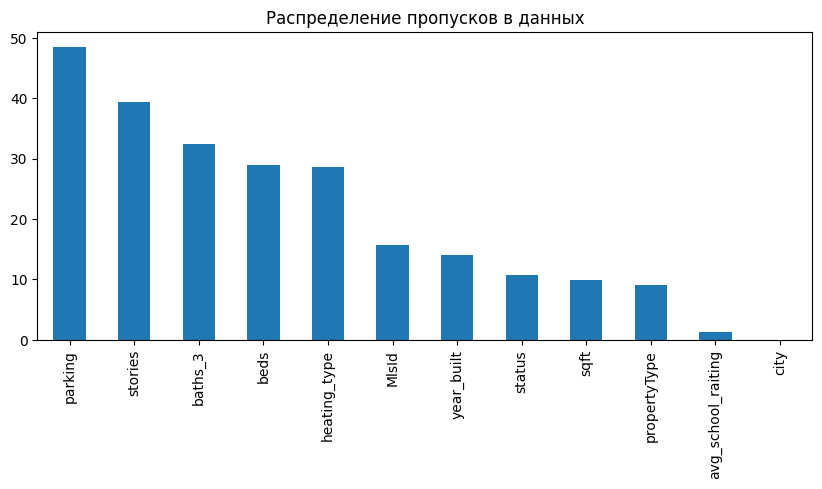

In [497]:
#построим гистограмму пропусков
cols_with_null.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков в данных'
);

>видим, что наибольшее количество пропусков в признаках heating_type, beds, baths, parking и stories

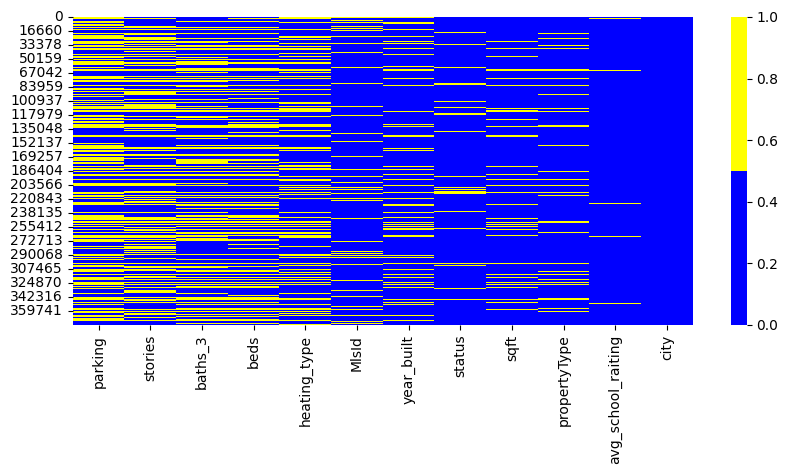

In [498]:
#построим тепловую карту пропусков
colors = ['blue', 'yellow'] 
fig = plt.figure(figsize=(10, 4))
cols = cols_with_null.index
ax = sns.heatmap(
    data_dedupped[cols].isnull(),
    cmap=sns.color_palette(colors),
)

>из тепловой карты пропусков видим, что пропуски в  heating_type, beds, parking и stories пересекаются. если удалим все пропуски в признаке heating_type, а их 28,5%, то количество пропусков в остальных перечисленных признаках уменьшится

In [194]:
# удалим все пропуски в признаке heating_type
data_temp = data_dedupped.dropna(subset=['heating_type'])

In [195]:
# посмотрим на оставшиеся пропуски
data_temp.isnull().mean()*100

status                11.657774
propertyType           3.752144
city                   0.002754
sqft                   2.955758
zipcode                0.000000
beds                  17.893511
state                  0.000000
stories               27.040150
MlsId                 14.278688
target                 0.000000
baths_3               22.748949
year_built             2.452115
heating_type           0.000000
parking               34.659726
numb_schools           0.000000
avg_school_raiting     0.956136
squaire                0.000000
dtype: float64

In [620]:
#посмотрим на описательную статистику:
data_temp.describe()

,beds,stories,target,baths_3,year_built,numb_schools,avg_school_raiting,squaire
count,208672.000000,185426.000000,2.541480e+05,196332.000000,247916.000000,254148.000000,251718.000000,2.541480e+05
mean,3.340750,1.626228,6.048210e+05,3.027837,1979.268309,4.266439,6.967337,7.240905e+03
std,1.410179,0.950936,1.603095e+06,12.930061,32.802329,5.007306,1.584803,1.820276e+06
min,0.000000,0.000000,3.930000e+02,0.000000,1057.000000,1.000000,1.000000,0.000000e+00
25%,3.000000,1.000000,1.999000e+05,2.000000,1958.000000,3.000000,6.250000,1.232000e+03
50%,3.000000,1.000000,3.250000e+05,2.500000,1985.000000,3.000000,7.166667,1.775000e+03
75%,4.000000,2.000000,5.699000e+05,3.000000,2006.000000,4.000000,8.000000,2.569000e+03
max,144.000000,5.000000,1.950000e+08,750.000000,2022.000000,65.000000,10.000000,7.959794e+08


>видим очевидные выбросы в признаках baths  - 750 ванных комнат в доме это мадовероятно. 144 спальни тоже вряд ли. Нулевые значения для baths, beds и squaire тоже. Удалим выбросы.

In [500]:
data_temp[(data_temp['baths_3'] == 0) | (data_temp['baths_3'] > 80)]

,status,propertyType,city,sqft,zipcode,beds,state,stories,MlsId,target,baths_3,year_built,heating_type,parking,numb_schools,avg_school_raiting,squaire
3594,active,NaN,DENVER,873,80204,NaN,CO,NaN,7106586,348900.0,750.0,1981.0,gas,NaN,4,4.000000,873
7564,active,NaN,DENVER,1864,80204,NaN,CO,NaN,5419627,560000.0,750.0,1936.0,other,NaN,3,2.000000,1864
7839,pending,multi_family,Poinciana,2324,34759,NaN,FL,1.0,S5025646,314000.0,0.0,2019.0,electric,NaN,8,2.200000,2324
9810,active,NaN,DENVER,906,80204,NaN,CO,NaN,3096963,395000.0,750.0,1954.0,gas,NaN,3,2.000000,906
11118,for sale,single_family,McAllen,3770,78503,4.0,TX,1.0,NaN,449000.0,241.0,2014.0,forced_air,two_spaces,3,7.500000,3770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337353,active,NaN,DENVER,1382,80204,NaN,CO,NaN,9843720,539000.0,750.0,2019.0,gas,NaN,3,2.000000,1382
343558,active,modern,DENVER,1214,80204,NaN,CO,NaN,2316488,919500.0,750.0,2019.0,forced_air,NaN,3,2.000000,1214
350247,pending,multi_family,Rotonda West,2546,33947,NaN,FL,1.0,D6109324,415000.0,0.0,2020.0,central,NaN,8,5.666667,2546
362518,active,NaN,DENVER,2440,80204,NaN,CO,NaN,8902812,1095000.0,750.0,2019.0,gas,NaN,4,4.000000,2440


In [196]:
#удалим записи с числом ванных комнат, равным 0, и больше, чем 80
outliers = data_temp[(data_temp['baths_3'] == 0) | (data_temp['baths_3'] > 80)]
data_cleaned = data_temp.drop(outliers.index, axis=0)
print(f'Результирующее число записей: {data_cleaned.shape[0]}')

Результирующее число записей: 254064


In [337]:
display(data_cleaned[data_cleaned['beds'] > 100])

,status,propertyType,city,sqft,zipcode,beds,state,stories,MlsId,target,baths_3,year_built,heating_type,parking,numb_schools,avg_school_raiting,squaire
7324,active,multi_family,Laredo,62376,78045,144.0,TX,NaN,20193851,1590000.0,2.0,NaN,central,NaN,8,7.0,62376


In [197]:
#удалим записи с числом спален, равным 0, и больше, чем 100
data_cleaned = data_cleaned.drop(index=data_cleaned[(data_cleaned['beds'] > 100) | (data_cleaned['beds'] == 0)].index)

In [417]:
data_cleaned[data_cleaned['squaire'] > 500000]

,status,propertyType,city,sqft,zipcode,beds,state,stories,MlsId,target,baths_3,year_built,heating_type,parking,numb_schools,avg_school_raiting,squaire
25260,for sale,land,Sacramento,588060,95829,NaN,CA,NaN,19006710,828000.0,NaN,NaN,gas,NaN,3,7.666667,588060
31380,for sale,coop,Woodside,743160,11377,2.0,NY,4.0,NaN,439000.0,NaN,1935.0,other,other,6,7.000000,743160
31679,for sale,coop,Forest Hills,575600,11375,2.0,NY,1.0,NaN,769000.0,2.0,1965.0,other,other,3,8.166667,575600
37394,for sale,land,San Antonio,2585006,78255,NaN,TX,NaN,1274965,138000.0,NaN,NaN,gas,NaN,3,9.000000,2585006
62736,for sale,single_family,Cincinnati,795979430,45225,2.0,OH,1.0,1230095,27500.0,2.0,1901.0,forced_air,attached_garage,11,6.227273,795979430
75228,for sale,coop,New York,967300,10022,NaN,NY,5.0,4049248,825000.0,2.0,1969.0,gas,one_space,7,8.928571,967300
82974,for sale,land,Panama City,683892,32404,3.0,FL,1.0,690035,199000.0,2.0,1998.0,forced_air,detached_garage,3,6.666667,683892
123367,for sale,land,San Antonio,794099,78221,3.0,TX,1.0,1249702,695000.0,NaN,1970.0,forced_air,attached_garage,1,6.500000,794099
144520,for sale,land,Pearland,566280,77584,NaN,TX,NaN,48208892,1000000.0,NaN,2001.0,other,attached_garage,3,7.166667,566280
196586,for sale,land,McAllen,1239282,78504,NaN,TX,NaN,322651,4100000.0,NaN,NaN,electric,NaN,3,7.833333,1239282


In [340]:
data_cleaned[data_cleaned['squaire'] > 100000]

,status,propertyType,city,sqft,zipcode,beds,state,stories,MlsId,target,baths_3,year_built,heating_type,parking,numb_schools,avg_school_raiting,squaire
136,for sale,single_family,Bayside,109200,11361,NaN,NY,NaN,3184158,270000.0,NaN,1963.0,other,NaN,3,9.000000,109200
318,for sale,coop,Bayside,373772,11360,NaN,NY,1.0,3184266,239000.0,NaN,1961.0,other,attached_garage,3,8.833333,373772
2660,for sale,coop,Flushing,260961,11354,2.0,NY,1.0,3136875,349990.0,NaN,1952.0,other,attached_garage,3,8.166667,260961
3289,for sale,coop,Bayside,157080,11360,3.0,NY,1.0,3185169,368000.0,2.0,1961.0,other,attached_garage,3,8.833333,157080
4741,for sale,coop,Bayside,324261,11360,NaN,NY,1.0,3162642,359000.0,NaN,1969.0,other,NaN,3,8.833333,324261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366407,for sale,single_family,Rego Park,580800,11374,3.0,NY,NaN,3158817,539888.0,2.0,1960.0,other,NaN,3,8.166667,580800
366848,for sale,coop,Forest Hills,215735,11375,2.0,NY,5.0,NaN,530000.0,NaN,1956.0,forced_air,NaN,3,8.500000,215735
367110,for sale,coop,Rego Park,452905,11374,NaN,NY,NaN,3120019,290000.0,NaN,1952.0,other,NaN,3,8.333333,452905
375073,for sale,coop,Bayside,328560,11360,NaN,NY,1.0,3119694,425000.0,NaN,1969.0,other,attached_garage,3,8.833333,328560


In [198]:
#удалим строки, где площадь больше 500000 кв.фут.
data_cleaned = data_cleaned.drop(index=data_cleaned[data_cleaned['squaire'] > 500000].index)

In [199]:
#рассмотрим объекты, у которых площадь больше 10000 и меньше 500000 кв.фут
data_big_squaire = data_cleaned[data_cleaned['squaire'] > 10000]
#сгруппируем эти данные по типу собственности и этажности и посмотрим как это отражается на средней площади
data_gr = data_big_squaire.groupby(['propertyType', 'stories'])['squaire'].mean()
data_gr = pd.DataFrame(data_gr)
data_gr = data_gr.reset_index()

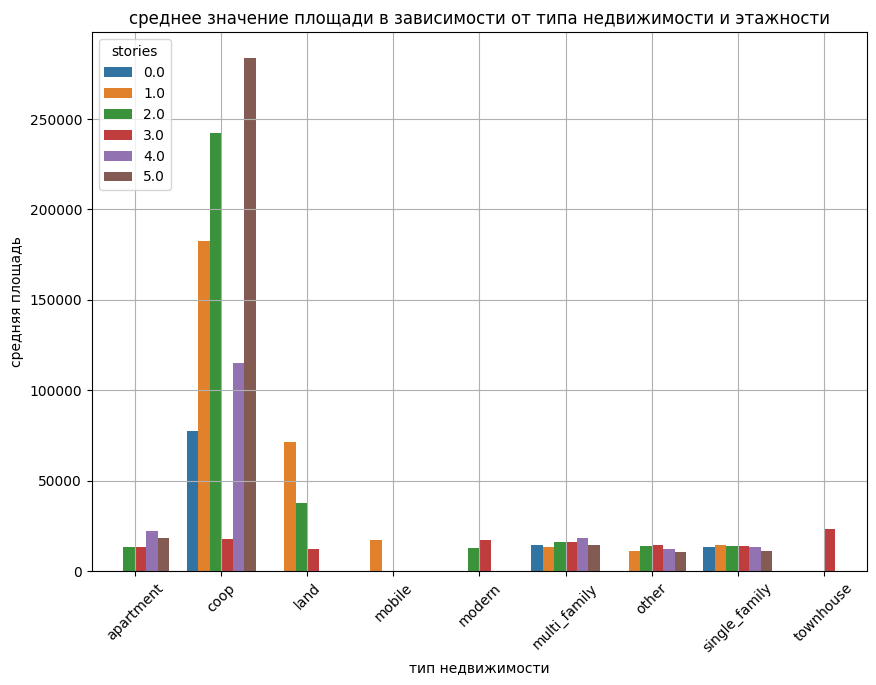

In [200]:
#отобразим эту группировку на графике
fig = plt.figure(figsize=(10, 7))
barplot = sns.barplot(data=data_gr, y='squaire', x='propertyType', hue='stories')
barplot.set_title('среднее значение площади в зависимости от типа недвижимости и этажности');
barplot.set_xlabel('тип недвижимости');
barplot.set_ylabel('средняя площадь');
barplot.xaxis.set_tick_params(rotation=45)
barplot.grid()

In [201]:
data_big_squaire.shape[0]

1405

>видим, что наибольшая площадь характерна для кооперативной недвижимости и земельных участков, это не противоречит логике. При этом среди объектов с большой площадью в кооперативе преобладают 1 этажные постройки. Это, конечно странно, но возможно, что сюда тоже входит земля, просто называется кооперативом

>таких данных (с большой площадью) не так много, учитывая общее количество данных, и все-таки лучше их удалить. Оставим порог 50 000 кв.фут

In [202]:
#удалим записи, в которых площадь менее 15 и более 50000 кв.фут.
outliers = data_cleaned[(data_cleaned['squaire'] < 15) | (data_cleaned['squaire'] > 50000)]
data_cleaned = data_cleaned.drop(outliers.index, axis=0)
print(f'Результирующее число записей: {data_cleaned.shape[0]}')

Результирующее число записей: 244497


In [422]:
#посмотрим на данные, где год постройки менее 1700 года
data_cleaned[data_cleaned['year_built']<1700]

,status,propertyType,city,sqft,zipcode,beds,state,stories,MlsId,target,baths_3,year_built,heating_type,parking,numb_schools,avg_school_raiting,squaire
149924,other,single_family,Logan,1208,43138,3.0,OH,NaN,9922581,79000.0,2.0,1208.0,other,other,6,6.250000,1208
172723,active,single_family,Ocala,1042,34482,2.0,FL,1.0,562474,104900.0,2.0,1057.0,central,NaN,8,3.333333,1042


In [203]:
#удалим эти записи
data_cleaned = data_cleaned.drop(index=data_cleaned[data_cleaned['year_built'] < 1700].index)

In [204]:
# удалим все пропуски в признаках, где их менее 5%
data_cleaned = data_cleaned.dropna(subset=['propertyType', 'year_built', 'city', 'avg_school_raiting'])

In [205]:
data_cleaned.isnull().mean()*100

status                12.366606
propertyType           0.000000
city                   0.000000
sqft                   0.000000
zipcode                0.000000
beds                  13.085993
state                  0.000000
stories               24.035939
MlsId                 14.885111
target                 0.000000
baths_3               17.689809
year_built             0.000000
heating_type           0.000000
parking               30.514758
numb_schools           0.000000
avg_school_raiting     0.000000
squaire                0.000000
dtype: float64

In [206]:
data_cleaned = data_cleaned.drop(['MlsId', 'sqft'], axis=1)

In [207]:
data_cleaned.shape[0]

230613

In [208]:
#удалим строки, где 2 и более пропусков:
m = data_cleaned.shape[1] #число признаков 
combine_data = data_cleaned.dropna(thresh=m-2, axis=0)

In [209]:
combine_data.shape[0]

201656

In [210]:
#создаем словарь имя столбца: число(признак) на который надо заменить пропуски
values = {
    'status': combine_data['status'].mode()[0],
    'stories': combine_data['stories'].mode()[0],
    'parking': combine_data['parking'].mode()[0]
    
}
#заполняем пропуски в соответствии с заявленным словарем
data = combine_data.fillna(values)
#выводим результирующую долю пропусков
data.isnull().mean()*100

status                0.000000
propertyType          0.000000
city                  0.000000
zipcode               0.000000
beds                  2.017297
state                 0.000000
stories               0.000000
target                0.000000
baths_3               6.851271
year_built            0.000000
heating_type          0.000000
parking               0.000000
numb_schools          0.000000
avg_school_raiting    0.000000
squaire               0.000000
dtype: float64

In [211]:
#заполним пропускисредним значением:
data['beds'] = data['beds'].fillna(data['beds'].mean())
data['baths_3'] = data['baths_3'].fillna(data['beds'].mean())

In [635]:
data.describe()

,beds,stories,target,baths_3,year_built,numb_schools,avg_school_raiting,squaire
count,201656.000000,201656.000000,2.016560e+05,201656.000000,201656.000000,201656.000000,201656.000000,201656.000000
mean,3.365533,1.493891,6.101371e+05,2.850727,1978.935811,4.345832,7.202196,2219.143596
std,1.296775,0.880532,1.596967e+06,1.372079,32.757129,5.403208,1.405359,1566.602365
min,1.000000,0.000000,3.930000e+02,0.750000,1700.000000,1.000000,1.000000,31.000000
25%,3.000000,1.000000,2.020900e+05,2.000000,1957.000000,3.000000,6.500000,1314.000000
50%,3.000000,1.000000,3.297995e+05,3.000000,1985.000000,3.000000,7.333333,1836.000000
75%,4.000000,2.000000,5.780000e+05,3.365533,2006.000000,4.000000,8.166667,2631.000000
max,53.000000,5.000000,1.650000e+08,60.000000,2021.000000,65.000000,10.000000,48871.000000


In [518]:
#рассмотрим записи с целевым признаком больше 40 млн
data[data['target']>40000000]

,status,propertyType,city,zipcode,beds,state,stories,target,baths_3,year_built,heating_type,parking,numb_schools,avg_school_raiting,squaire
7166,for sale,single_family,Los Angeles,90077,8.0,CA,1.0,59900000.0,12.000000,2018.0,forced_air,attached_garage,3,8.500000,24000
34739,active,single_family,Los Angeles,90069,6.0,CA,1.0,42500000.0,3.365533,2019.0,central,no_parking,8,7.200000,17000
54164,for sale,single_family,Beverly Hills,90210,12.0,CA,2.0,110000000.0,24.000000,2000.0,forced_air,carport,3,8.666667,38000
63865,for sale,single_family,Los Angeles,90077,7.0,CA,2.0,75000000.0,10.000000,1931.0,forced_air,other,3,8.666667,20000
72057,for sale,single_family,Coral Gables,33156,6.0,FL,2.0,55000000.0,12.000000,2007.0,forced_air,attached_garage,6,9.000000,12930
93865,for sale,single_family,Los Angeles,90049,9.0,CA,4.0,56000000.0,15.000000,2018.0,forced_air,other,3,8.500000,18850
110402,for sale,single_family,Los Angeles,90024,7.0,CA,2.0,49500000.0,12.000000,2017.0,forced_air,other,3,8.666667,18000
119862,for sale,single_family,Los Angeles,90077,9.0,CA,3.0,115000000.0,10.000000,1936.0,forced_air,attached_garage,3,8.666667,12201
143528,for sale,single_family,Beverly Hills,90210,20.0,CA,3.0,165000000.0,23.000000,1998.0,forced_air,attached_garage,3,8.666667,28660
150856,for sale,single_family,San Francisco,94133,6.0,CA,1.0,40500000.0,8.000000,2018.0,other,four_spaces,3,9.000000,9495


In [212]:
#удалим эти записи, посчитав их выбросами
data = data.drop(index=data[data['target']>40000000].index)

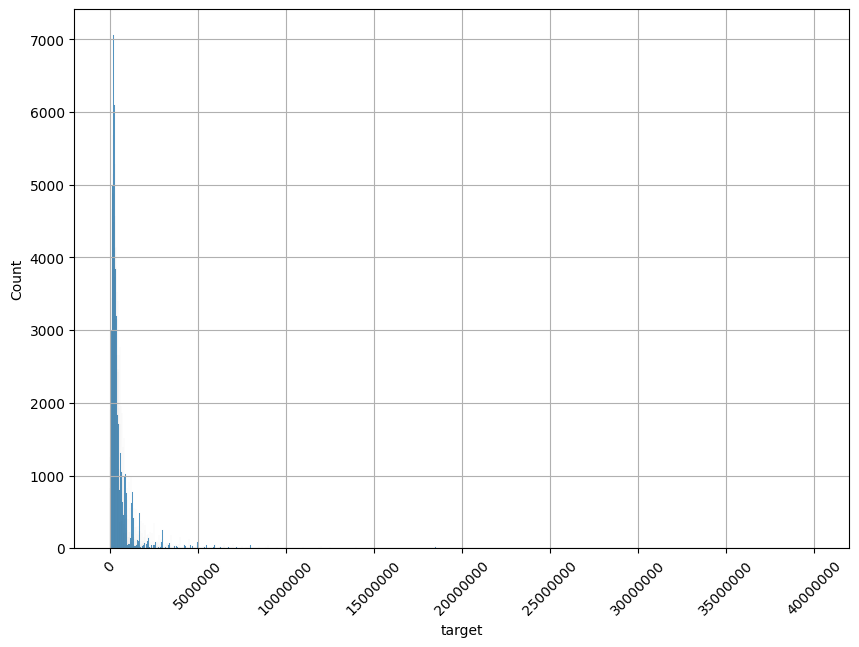

In [213]:
#посмотрим теперь на гистограмму целевого признака
fig = plt.figure(figsize=(10, 7))
histplot = sns.histplot(data=data, x='target')
histplot.xaxis.set_major_formatter('{:.0f}'.format)
histplot.xaxis.set_tick_params(rotation=45);
histplot.grid()

>наибольшая часть выбросов по-прежнему сосредоточена в зоне 0, т.к. очевидно еще есть данные с небольшой частотой и большими значениями (похожие на выбросы)

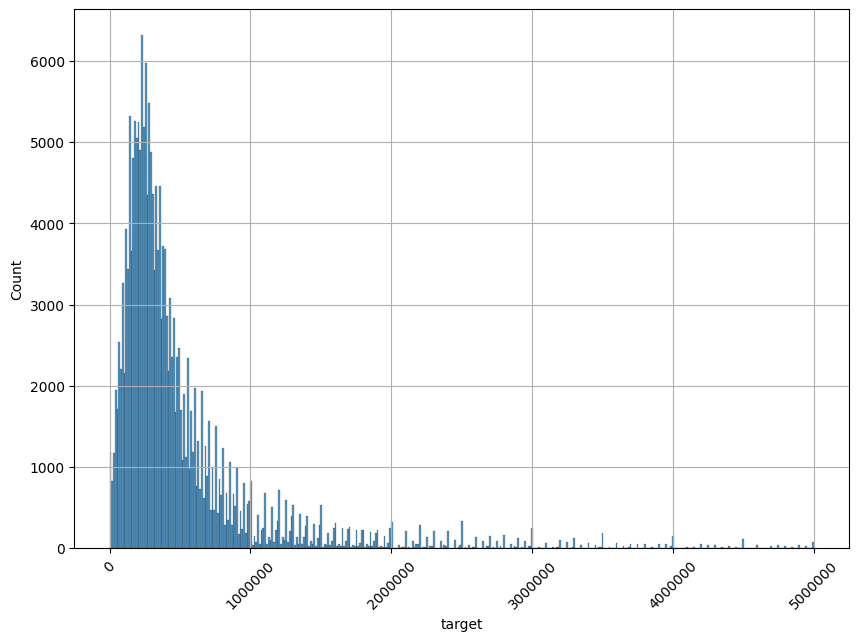

In [215]:
#посморим да гистограмму данных до 5 млн.фут
lower_price_data = data[data['target']<5000000]
fig = plt.figure(figsize=(10, 7))
histplot = sns.histplot(data=lower_price_data, x='target')
histplot.xaxis.set_major_formatter('{:.0f}'.format)
histplot.xaxis.set_tick_params(rotation=45);
histplot.grid()

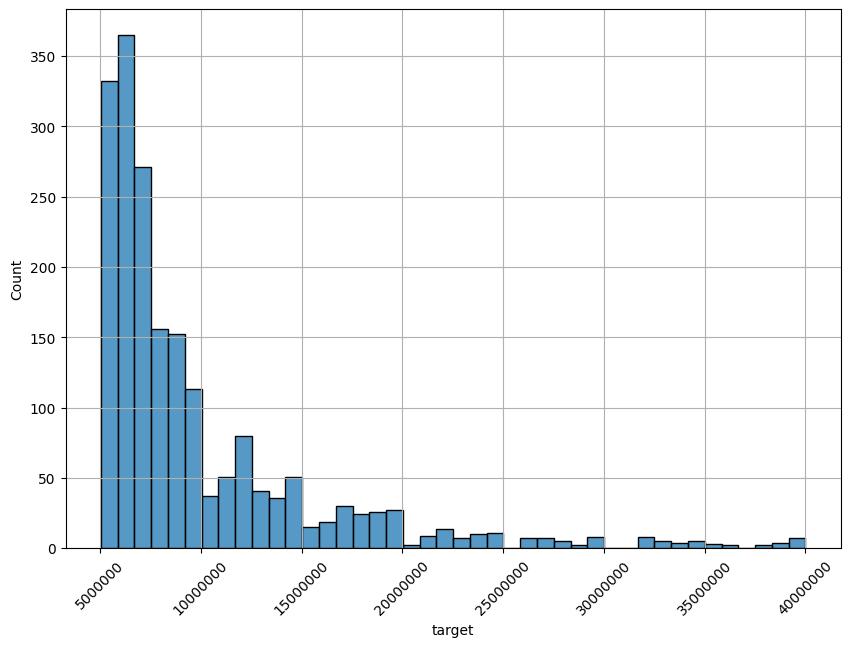

In [216]:
#отфильтруем данные с ценой больше 5 млн и посмотрим на их гистограмму
hi_price_prop = data[(data['target']>5000000)]
fig = plt.figure(figsize=(10, 7))
histplot = sns.histplot(data=hi_price_prop, x='target')
histplot.xaxis.set_major_formatter('{:.0f}'.format)
histplot.xaxis.set_tick_params(rotation=45);
histplot.grid()

In [217]:
#временно введем новую переменную - стоимость квадратного метра
hi_price_prop['price_per_ft'] = hi_price_prop['target']/hi_price_prop['squaire']

C:\Users\free-\AppData\Local\Temp\ipykernel_11000\2393110851.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hi_price_prop['price_per_ft'] = hi_price_prop['target']/hi_price_prop['squaire']


In [218]:
#сгруппируем данные и посмотрим на 10 объектов с самой высокой стоимостью квадратного метра
hi_price_prop.groupby(['year_built', 'status', 'propertyType', 'stories'])['price_per_ft'].mean().head(20).sort_values(ascending=False)

year_built  status            propertyType   stories
1880.0      new construction  coop           1.0        3368.280785
1882.0      for sale          coop           1.0        3184.134337
1860.0      new construction  coop           1.0        2942.681679
1825.0      active            single_family  3.0        2318.468824
1861.0      for sale          coop           1.0        2269.528501
1803.0      for sale          single_family  3.0        2106.149958
1854.0      for sale          townhouse      4.0        1757.575758
1886.0      for sale          single_family  3.0        1756.756757
1871.0      for sale          single_family  4.0        1623.376623
1867.0      for sale          single_family  4.0        1598.676957
1888.0      for sale          single_family  1.0        1455.223881
1890.0      for sale          single_family  0.0        1445.484581
1830.0      for sale          single_family  3.0        1350.786627
1870.0      for sale          single_family  4.0        1225.28

>видим, что это в основном старые сдания, возможно, имеющие историческую ценность. Не будем считать их выбросами

## 3. Разведывательный анализ данных

In [701]:
#сгруппируем данные пи посмотрим, как среднее значение целевого признака зависит от статуса продажи
grouped = data.groupby('status')['target'].mean()
grouped = pd.DataFrame(grouped)


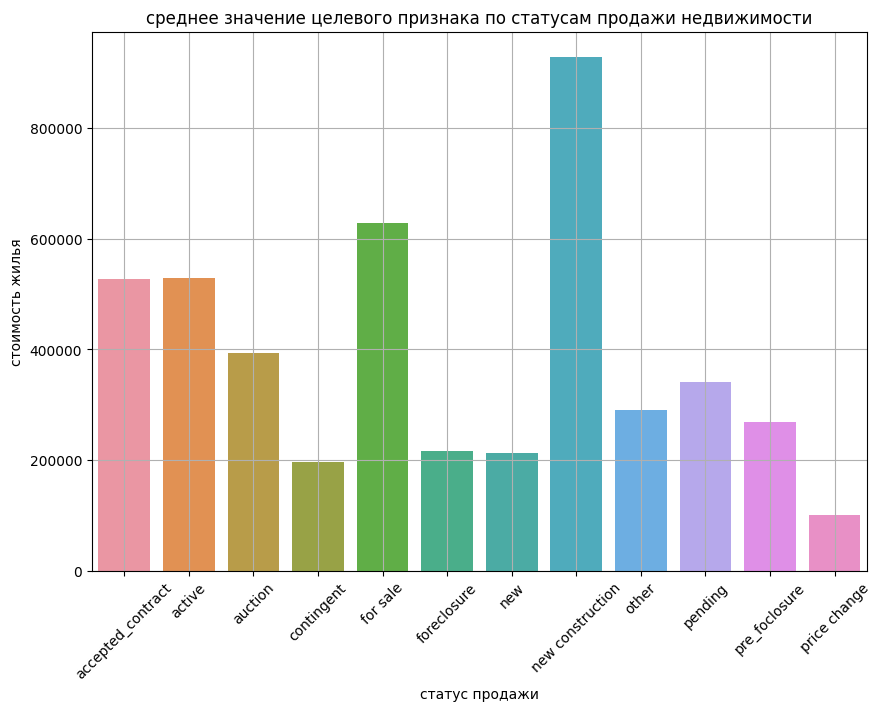

In [702]:
#отобразим это на графике
fig = plt.figure(figsize=(10, 7))
barplot = sns.barplot(data=grouped, y='target', x=grouped.index)
barplot.set_title('среднее значение целевого признака по статусам продажи недвижимости');
barplot.set_xlabel('статус продажи');
barplot.set_ylabel('стоимость жилья');
barplot.xaxis.set_tick_params(rotation=45)
barplot.grid()

> наибольшая стоимость жилья у нового строительства, статус "на продажу". Наименьшая цена у недвижимости, изъятой по долговым обязательствам или которой предстоит этот процесс (foreclosure и pre-foreclosure). Логике не противоречит

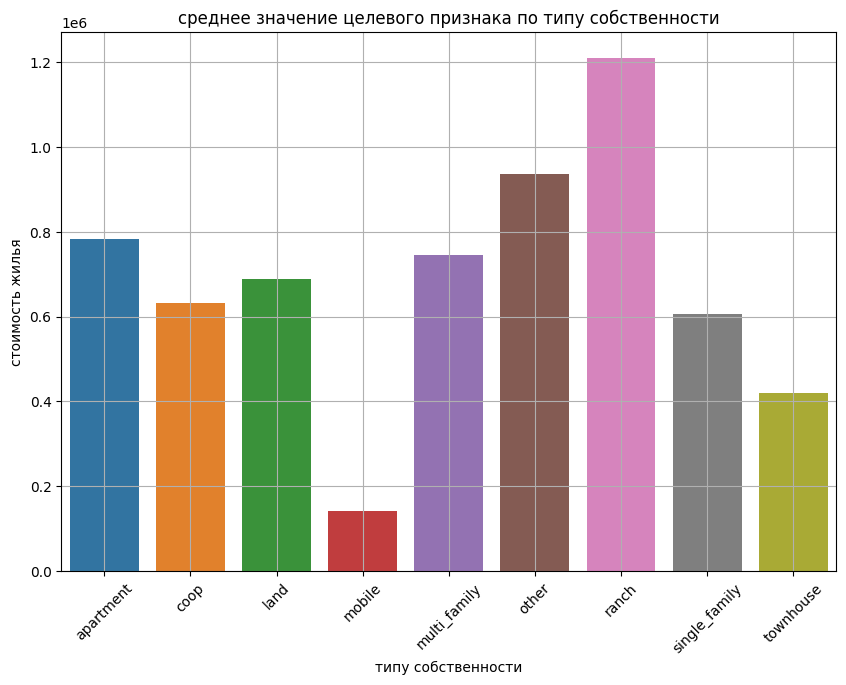

In [703]:
#сгруппируем данные пи посмотрим, как среднее значение целевого признака зависит от типа собственности
grouped_1 = data.groupby('propertyType')['target'].mean()
grouped_1 = pd.DataFrame(grouped_1)
fig = plt.figure(figsize=(10, 7))
barplot = sns.barplot(data=grouped_1, y='target', x=grouped_1.index)
barplot.set_title('среднее значение целевого признака по типу собственности');
barplot.set_xlabel('типу собственности');
barplot.set_ylabel('стоимость жилья');
barplot.xaxis.set_tick_params(rotation=45)
barplot.grid()

> наибольшая стоимость жилья у типа ranch, other и multi_family. Наименьшая цена у мобильной недвижимости

In [704]:
#посмотрим, какие городахи штаты наиболее привлекательны с точки зрения школького образования:
grouped_3 = data.groupby(['city', 'state'])['numb_schools','avg_school_raiting'].mean()
grouped_3.sort_values(by='avg_school_raiting', ascending=False).head(10)

C:\Users\free-\AppData\Local\Temp\ipykernel_23272\1752025061.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_3 = data.groupby(['city', 'state'])['numb_schools','avg_school_raiting'].mean()


,,numb_schools,avg_school_raiting
city,state,,
Ponte Vedra Beach,FL,3.000000,10.000000
Los Gatos,CA,3.000000,9.833333
Madeira,OH,3.000000,9.833333
St Johns,FL,3.000000,9.833333
Springs,TX,3.000000,9.833333
Porter,TX,3.000000,9.833333
West Lake Hills,TX,2.583333,9.791667
Downs,IL,2.000000,9.750000
Highland park,TX,3.000000,9.750000


>наиболее привлекательные штаты - Флорида (Ponte Vedra Beach, St Johns), Техас(Porter, Springs, West Lake Hills, Highland park, University Park), Огайо (Madeira), Иллиноис (Downs).

In [705]:
#выделяем имена числовых признаков в виде списка 
types = data.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['beds',
 'stories',
 'target',
 'baths_3',
 'year_built',
 'numb_schools',
 'avg_school_raiting',
 'squaire']

In [706]:
#удалим категориальные переменные
num_features.remove('stories')

> для каждого числового признака построим гистограмму  и диаграмму рассеяния, иллюстрирующую зависимость целевого признака от каждого из факторов.

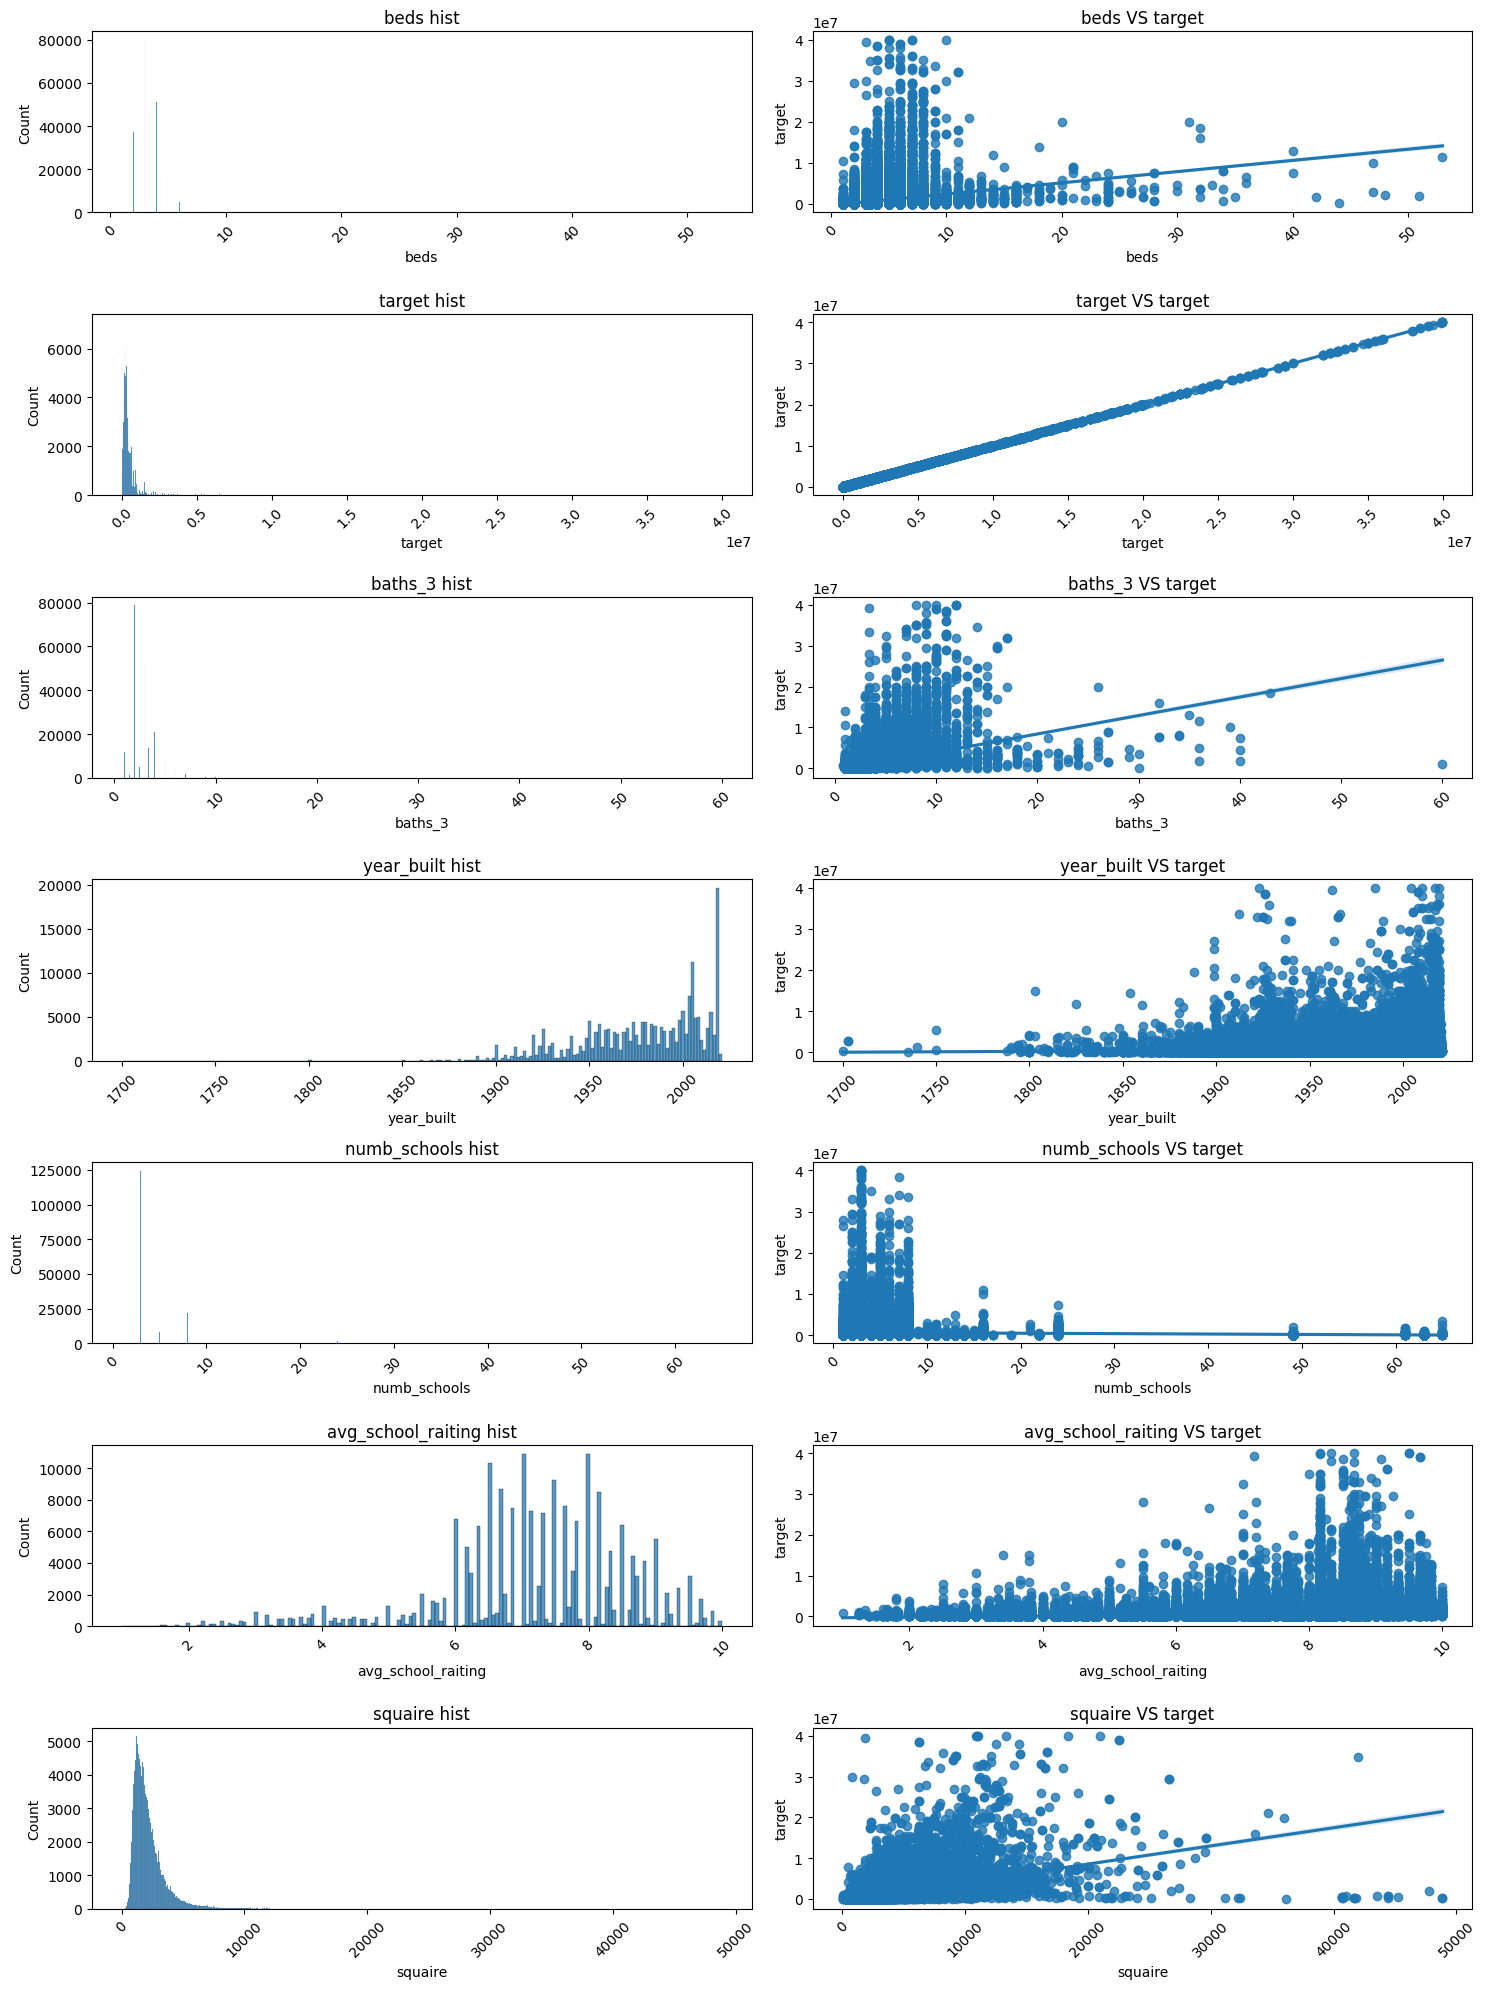

In [707]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=data, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=data, x=feature, y='target', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS target'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

> видим, что четкой корреляции с целевым признаком не прослеживается, распределение признаков далеко от нормального.

In [708]:
# Проверяем гипотезу о нормальности распределения признаков
H0 = 'распределение признака является нормальным'
Ha = 'признак не распределен нормально'
alpha=0.05
for feature in num_features:
    _, p=shapiro(data[feature])
    print('P of {} is {}'.format(feature, p))
    if p>alpha:
        print(f'Нулевая гипотеза принимается. {H0}')
    else:
        print(f'Нулевая гипотеза отвергается. {Ha}')


P of beds is 0.0
Нулевая гипотеза отвергается. признак не распределен нормально
P of target is 0.0
Нулевая гипотеза отвергается. признак не распределен нормально
P of baths_3 is 0.0
Нулевая гипотеза отвергается. признак не распределен нормально
P of year_built is 0.0
Нулевая гипотеза отвергается. признак не распределен нормально
P of numb_schools is 0.0
Нулевая гипотеза отвергается. признак не распределен нормально
P of avg_school_raiting is 0.0
Нулевая гипотеза отвергается. признак не распределен нормально
P of squaire is 0.0
Нулевая гипотеза отвергается. признак не распределен нормально


c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


> предположение подтвердилось, признаки не распределены нормально, поэтому потребуется нормализация данных

In [219]:
#закодируем признаки с большим количеством уникальных значений с помощью порядкового кодирования
ord_encoder = ce.OrdinalEncoder()
data_bin = ord_encoder.fit_transform(data[['status', 'propertyType', 'city', 'zipcode', 'state', 'parking']])
data = pd.concat([data, data_bin], axis=1)

In [220]:
#закодируем оставшийся признак heating_type с помощью get_dummies
dummies_data = pd.get_dummies(data, columns=['heating_type'])

In [221]:
#удалим ненужные столбцы
data = dummies_data.select_dtypes(exclude=['object'])

In [222]:
print('получившееся количество признаков: {}'.format(data.shape[1]))

получившееся количество признаков: 20


> проверим признаки на мультиколлинеарность:

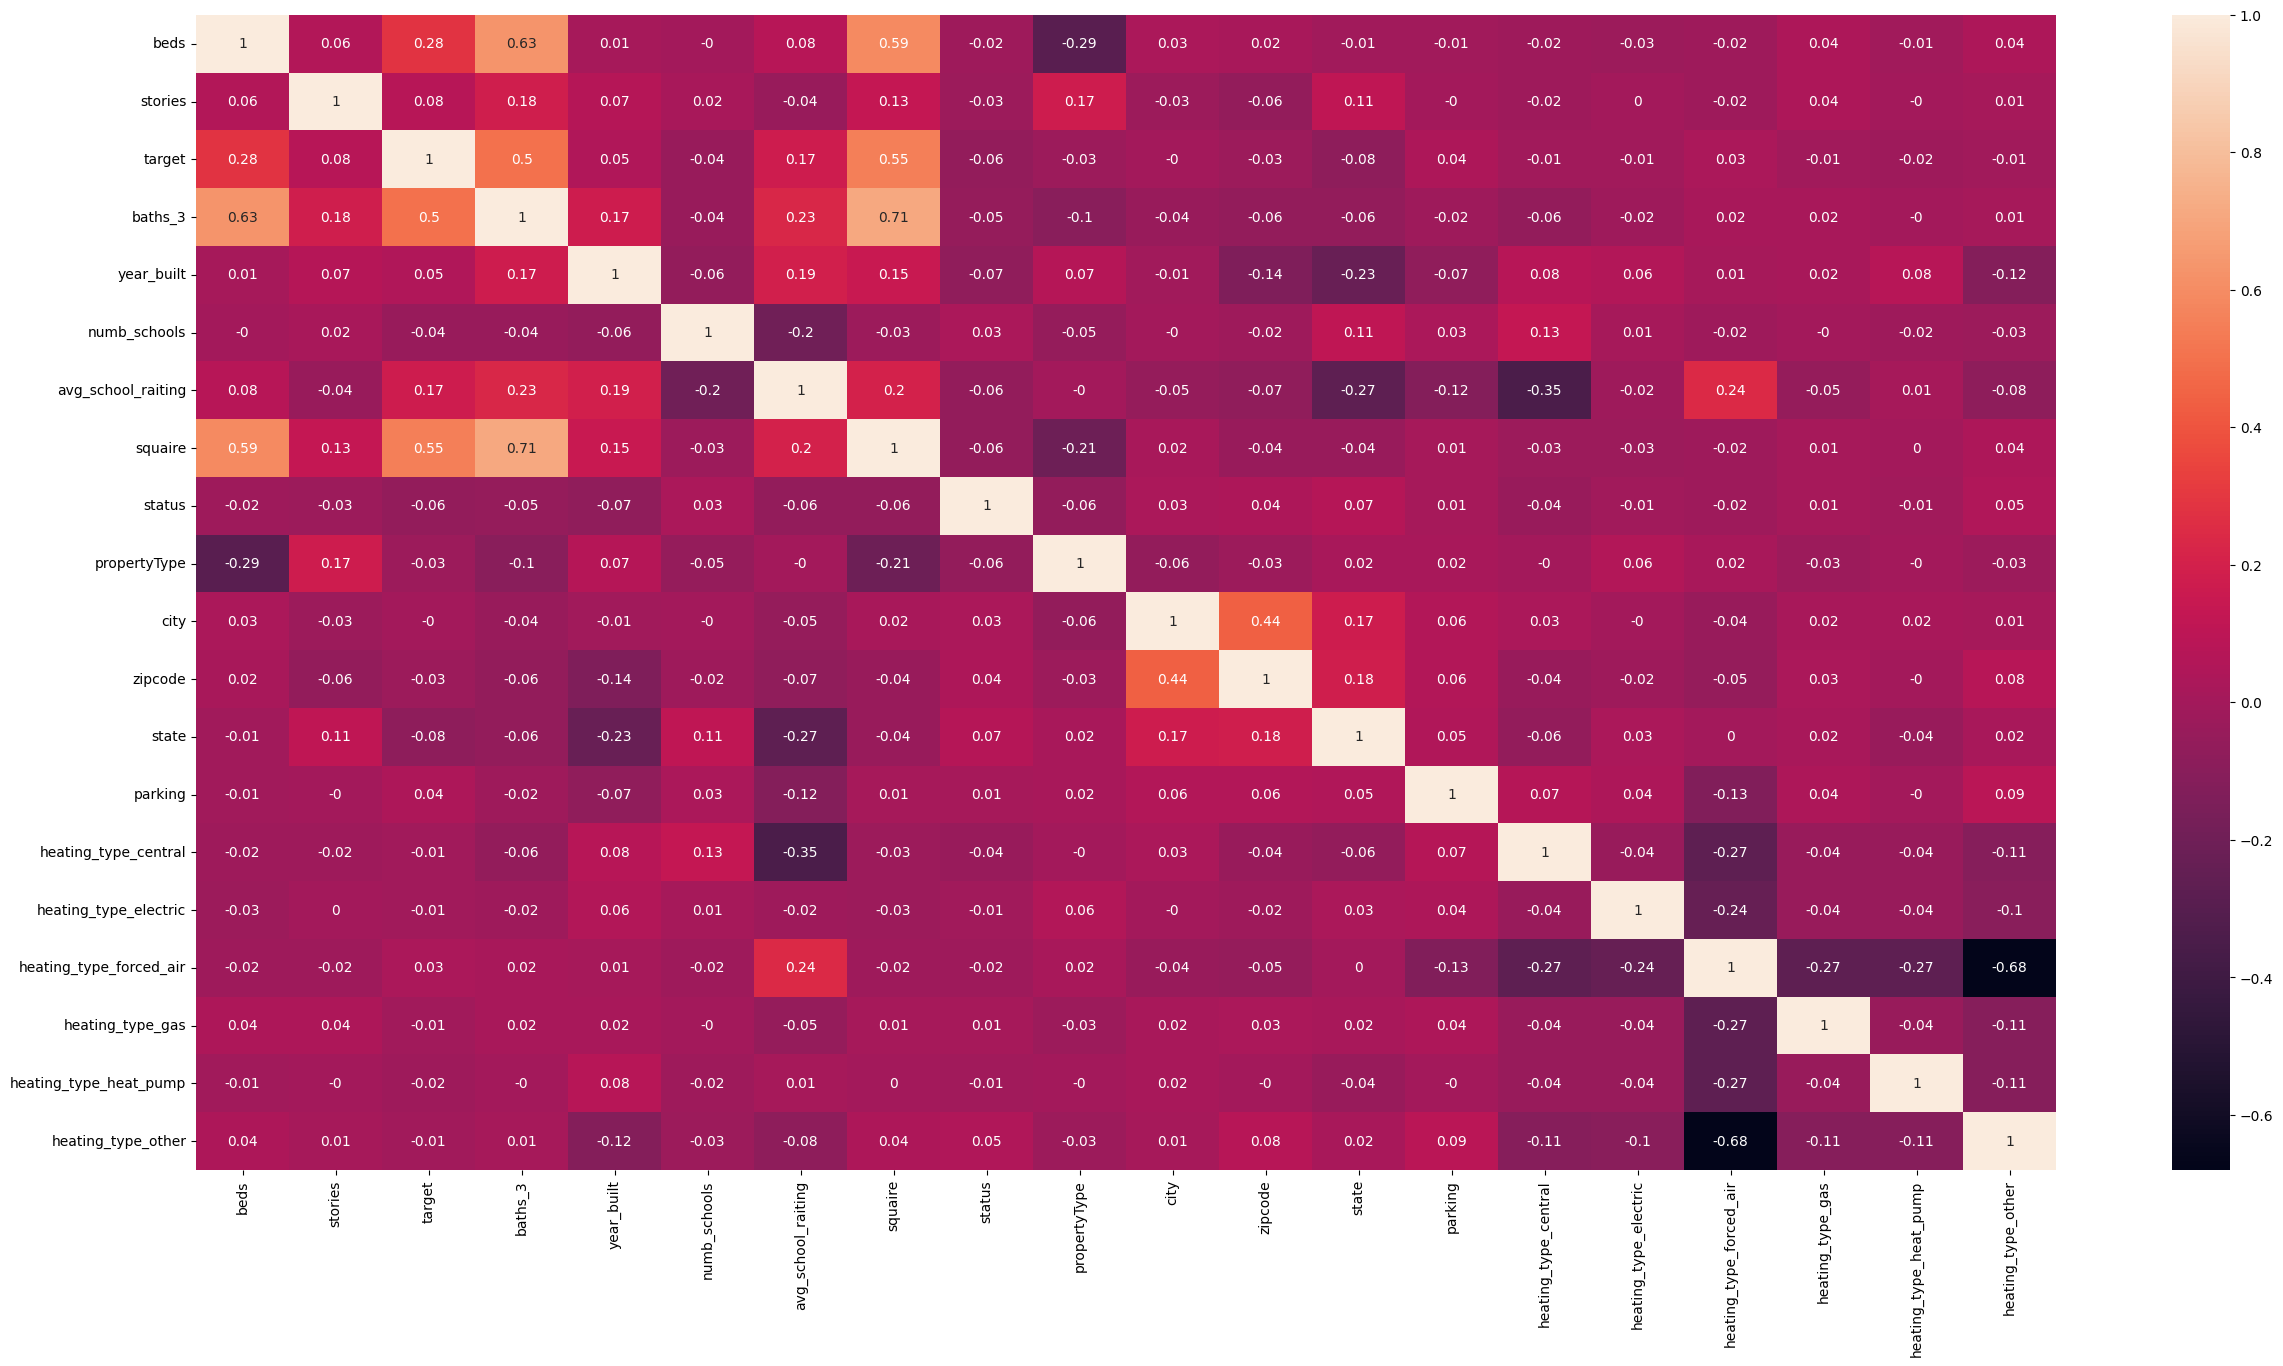

In [223]:
plt.figure(figsize = (30, 15))
sns.heatmap(round((data.corr()), 2), annot = True);

> видим сильную связь между признаками bath_3 и squaire, но не будем пока удалять bath_3

In [224]:
#переведем признаки с float в целочисленный формат
data['year_built'] = data['year_built'].astype(int)


In [225]:
#сохраним данные
data.to_csv('data_cleaned.csv', index=False)

## 4. Построение модели

### 4.1 Подготовка данных

In [226]:
df = pd.read_csv('data_cleaned.csv')

In [227]:
#разобьем датасет на зависимые и независимые переменные
X = df.drop(['target'], axis=1)
y = df['target']
#разделим выборку на тернировочную и тестовую в отношении 5:1 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

>поскольку признаков нолучилось немного, не будем выделять основные с помощью KBest

> т.к. необходимо предсказать стоимость жилья, это задача регрессии

In [228]:
# нормальзуем данные
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

### 4.2 Модель случайного леса. 
Строим именно эту модель, т.к. она дала наивысшие результаты

In [229]:
rf = ensemble.RandomForestRegressor(
    n_estimators = 100,
    criterion = 'squared_error',
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)
rf.fit(X_train_scaled, y_train)
y_pred_test_rf = rf.predict(X_test_scaled)
y_pred_train_rf = rf.predict(X_train_scaled)

In [230]:
print('Train MAPE: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_train, y_pred_train_rf)*100))
print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_pred_train_rf)))
print('Test MAPE: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_test, y_pred_test_rf)*100))
print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_pred_test_rf)))

Train MAPE: 221.80
Train R^2: 0.563
Test MAPE: 201.14
Test R^2: 0.511


>метрики получились плохие, средняя ошибка составляет более 200%

>посмотрим, какие признаки оказывают наибольшее влияние на прогноз

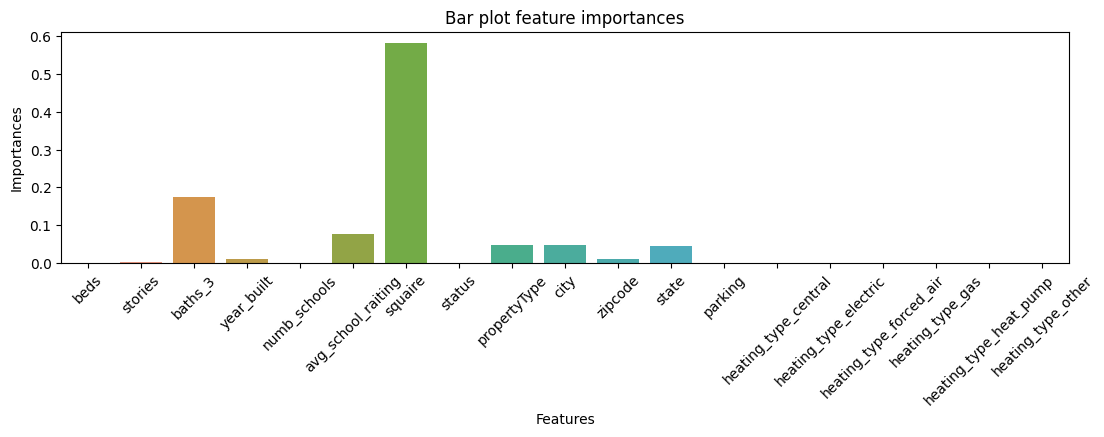

In [724]:
fig, ax = plt.subplots(figsize=(13, 3)) #фигура + координатная плоскость
feature = X.columns #признаки
feature_importances = rf.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
barplot = sns.barplot(x=feature, y=feature_importances, ax=ax);
#Добавляем подпись графику, осям абцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances')
barplot.xaxis.set_tick_params(rotation=45);


>видим, что наибольшее влияние на прогноз оказывает признак площади объекта, причем он превосходит по важности все лругие признаки в несколько раз

### 4.3 Замена целевой переменной. 
Попробуем рассмотреть в качестве целевой переменной не стоимость объекта, а стоимость квадратного метра объекта. Этот признак более точно будет отражать его стоимость, чем просто общая цена. 

In [231]:
df = pd.read_csv('data_cleaned.csv')
df['price_per_ft'] = df['target']/df['squaire']

(1.0, 5000.0)

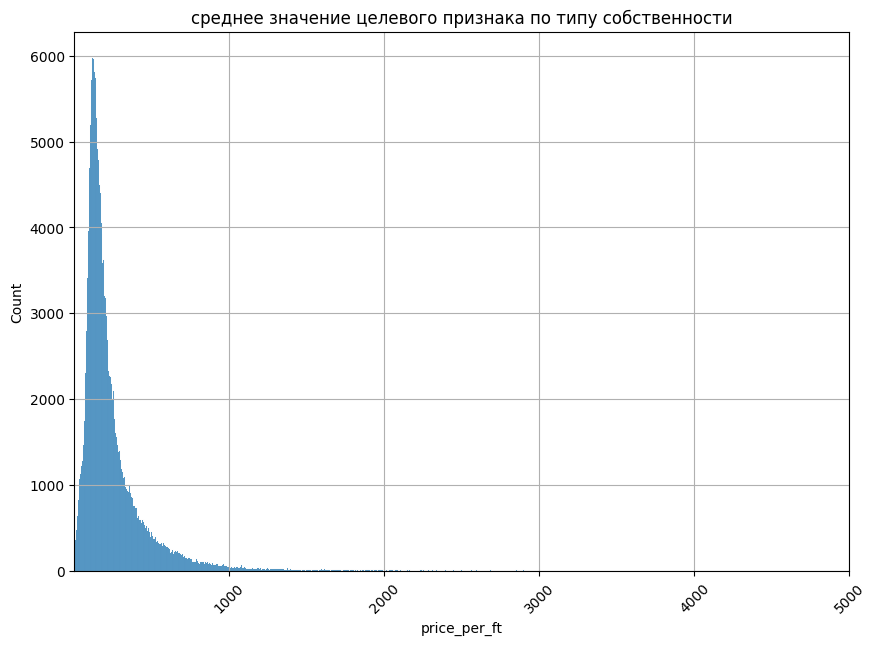

In [232]:
#посмотрим на гистограмму стоимости квадратного мета
fig = plt.figure(figsize=(10, 7))
histplot = sns.histplot(data=df, x='price_per_ft')
histplot.set_title('среднее значение целевого признака по типу собственности');
histplot.xaxis.set_tick_params(rotation=45)
histplot.grid()
histplot.set_xlim(1, 5000)

>видим очень близкие к нулю значения, а также немногочисленные очень высокие значения - 2000 и более

In [86]:
#посмотрим на значения меньше 15 и больше 1500
df[(df['price_per_ft']<15) | (df['price_per_ft']>1500)]

,beds,stories,target,baths_3,year_built,numb_schools,avg_school_raiting,squaire,status,propertyType,...,zipcode,state,parking,heating_type_central,heating_type_electric,heating_type_forced_air,heating_type_gas,heating_type_heat_pump,heating_type_other,price_per_ft
73,3.0,1.0,8095000.0,4.000000,1928,2,9.750000,4532,2,3,...,71,7,1,0,0,1,0,0,0,1786.187114
250,7.0,3.0,24000000.0,9.000000,2016,3,8.166667,10330,2,1,...,221,5,1,0,0,1,0,0,0,2323.330106
369,4.0,4.0,15174000.0,6.000000,2019,3,7.000000,7587,2,3,...,36,11,1,0,0,1,0,0,0,2000.000000
744,6.0,2.0,1000.0,2.000000,1914,12,6.625000,2544,9,1,...,579,19,11,0,0,1,0,0,0,0.393082
789,3.0,1.0,6450000.0,4.000000,1861,1,5.500000,2842,2,3,...,608,15,1,0,0,1,0,0,0,2269.528501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201274,2.0,5.0,1750000.0,2.000000,1987,7,8.928571,1080,2,3,...,2965,8,1,0,0,1,0,0,0,1620.370370
201413,6.0,1.0,18995000.0,7.000000,2001,3,9.166667,7328,2,1,...,1175,2,4,0,0,1,0,0,0,2592.112445
201445,4.0,1.0,1000.0,3.365533,1923,12,6.666667,998,9,1,...,1067,19,11,0,0,1,0,0,0,1.002004
201469,3.0,1.0,8900000.0,3.000000,2003,3,8.166667,4379,2,3,...,1211,5,5,0,0,1,0,0,0,2032.427495


In [233]:
#удалим эти значения как выбросы
df = df.drop(index=df[df['price_per_ft']>1500].index)
df = df.drop(index=df[df['price_per_ft']<15].index)
#разобьем датасет на зависимые и независимые переменные
X = df.drop(['target', 'squaire', 'price_per_ft'], axis=1)
y = df['price_per_ft']
#разделим выборку на тернировочную и тестовую в отношении 5:1 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)
# нормальзуем данные
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [234]:
rf = ensemble.RandomForestRegressor(
    n_estimators = 100,
    criterion = 'poisson',
    min_samples_leaf = 3,
    max_depth = 20,
    random_state = 42
)
rf.fit(X_train_scaled, y_train)
y_pred_test_rf = rf.predict(X_test_scaled)
y_pred_train_rf = rf.predict(X_train_scaled)
print('Test MAPE: {:.5f}'.format(metrics.mean_absolute_percentage_error(y_test, y_pred_test_rf)*100))
print('Test R^2: {:.5f}'.format(metrics.r2_score(y_test, y_pred_test_rf)))

Test MAPE: 27.23726
Test R^2: 0.75496


>метрики получились гораздо лучше, пришлось, првавда, увеличить глубину до 20, но т.к. данных много, думаю, это позволительно

### 4.4 Оптимизация гиперпараметров модели случайного леса

In [91]:
#посмотрим, какие будут метрики, если подобрать оптимальные параметры:
param_grid = {'max_depth': list(range(7,25, 4)),
              'min_samples_leaf': list(range(3,9,2))} 
grid_search = GridSearchCV(
    estimator=ensemble.RandomForestRegressor(
        random_state=42 #генератор случайных чисел
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train_scaled, y_train) 
y_test_pred_rf_pg = grid_search.predict(X_test_scaled)

CPU times: total: 43 s
Wall time: 20min 26s


In [94]:
print('Test MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_pred_rf_pg)*100))
print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_pred_rf_pg)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

Test MAPE: 27.264
Test R^2: 0.751
Наилучшие значения гиперпараметров: {'max_depth': 23, 'min_samples_leaf': 3}


> с помощью подбора оптимальных параметров качество модели незначительно ухудшилось: MAPE мнемного выросла, и R^2 увеличился.

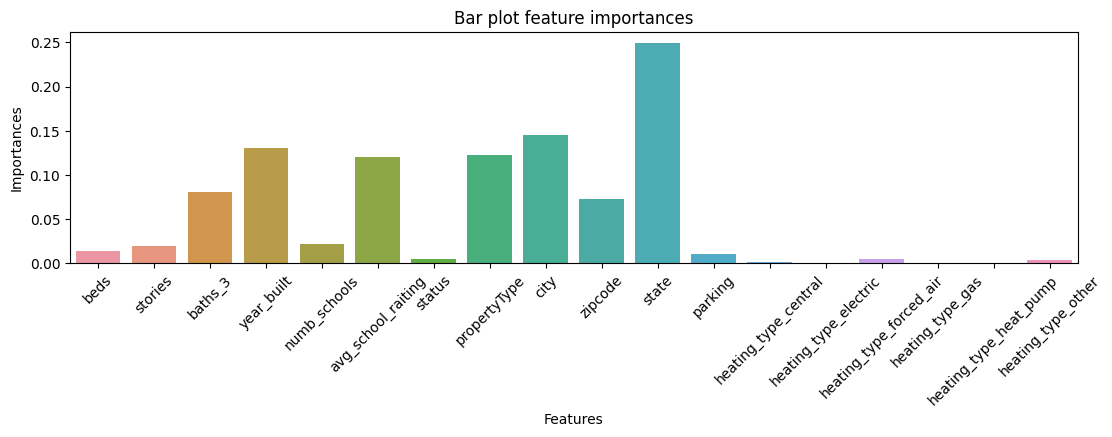

In [51]:
fig, ax = plt.subplots(figsize=(13, 3)) #фигура + координатная плоскость
feature = X.columns #признаки
feature_importances = rf.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
barplot = sns.barplot(x=feature, y=feature_importances, ax=ax);
#Добавляем подпись графику, осям абцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances')
barplot.xaxis.set_tick_params(rotation=45);

### 4.5 Отбор признаков с помощью SelectKBest

посмотрим, что изменится, если отобрать 10 наиболее важных признаков

In [101]:
df = pd.read_csv('data_cleaned.csv')
df['price_per_ft'] = df['target']/df['squaire']
df = df.drop(index=df[df['price_per_ft']>1500].index)
df = df.drop(index=df[df['price_per_ft']<15].index)
#разобьем датасет на зависимые и независимые переменные
X = df.drop(['target', 'squaire', 'price_per_ft'], axis=1)
y = df['price_per_ft']
#разделим выборку на тернировочную и тестовую в отношении 5:1 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

In [102]:
selector = SelectKBest(f_regression, k=13)
selector.fit(X_train, y_train)
selector.get_feature_names_out()

array(['stories', 'baths_3', 'numb_schools', 'avg_school_raiting',
       'status', 'propertyType', 'city', 'state', 'parking',
       'heating_type_forced_air', 'heating_type_gas',
       'heating_type_heat_pump', 'heating_type_other'], dtype=object)

In [103]:
X_train = X_train[['stories', 'baths_3', 'numb_schools', 'avg_school_raiting',
       'status', 'propertyType', 'city', 'state', 'parking',
       'heating_type_forced_air', 'heating_type_gas',
       'heating_type_heat_pump', 'heating_type_other']]
X_test = X_test[['stories', 'baths_3', 'numb_schools', 'avg_school_raiting',
       'status', 'propertyType', 'city', 'state', 'parking',
       'heating_type_forced_air', 'heating_type_gas',
       'heating_type_heat_pump', 'heating_type_other']]

In [104]:
# нормальзуем данные
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [105]:
rf = ensemble.RandomForestRegressor(
    n_estimators = 100,
    criterion = 'poisson',
    min_samples_leaf = 3,
    max_depth = 20,
    random_state = 42
)
rf.fit(X_train_scaled, y_train)
y_pred_test_rf = rf.predict(X_test_scaled)
y_pred_train_rf = rf.predict(X_train_scaled)

In [106]:
print('Test MAPE: {:.5f}'.format(metrics.mean_absolute_percentage_error(y_test, y_pred_test_rf)*100))
print('Test R^2: {:.5f}'.format(metrics.r2_score(y_test, y_pred_test_rf)))

Test MAPE: 30.41442
Test R^2: 0.71091


>метрики ухудшились, отбор признаков нецелесообразен

### 4.6 создание пайплайна и сериализация модели

> оптимальным является вариант модели случайного леса в п. 4.3, запишем его в пайплайн

In [111]:
df = pd.read_csv('data_cleaned.csv')
df['price_per_ft'] = df['target']/df['squaire']
#удалим эти значения как выбросы
df = df.drop(index=df[df['price_per_ft']>1500].index)
df = df.drop(index=df[df['price_per_ft']<15].index)
#разобьем датасет на зависимые и независимые переменные
X = df.drop(['target', 'squaire', 'price_per_ft'], axis=1)
y = df['price_per_ft']
#разделим выборку на тернировочную и тестовую в отношении 5:1 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)
# нормальзуем данные
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [112]:
# Создаём пайплайн, который включает нормализацию признаков и обучение модели
pipe_1 = Pipeline([  
  ('Scaling', MinMaxScaler()),
  ('Model', ensemble.RandomForestRegressor(n_estimators = 100,
    criterion = 'poisson',
    min_samples_leaf = 5,
    max_depth = 20))
  ])
# Обучаем пайплайн
pipe_1.fit(X_train, y_train)
y_pred_test = pipe_1.predict(X_test)
print('Test MAPE: {:.5f}'.format(metrics.mean_absolute_percentage_error(y_test, y_pred_test)*100))
print('Test R^2: {:.5f}'.format(metrics.r2_score(y_test, y_pred_test)))

Test MAPE: 27.68468
Test R^2: 0.74651


In [113]:
# Сериализуем pipeline и записываем результат в файл
with open('my_pipeline_2.pkl', 'wb') as output:
    pickle.dump(pipe_1, output)

>далее в помощью этого пайплайна создадим веб-сервис, определяющий цену недвижимости на основе вводимых характеристик 

>Вывод: в итоге выполнения данной дипломной работы удалось преобразовать имеющиеся признаки и построить модель случайного леса, прогнозирующую стоимость квадратного метра жилья. Наилучшая из построенных модель имеет среднюю абсолютную процентную ошибку 27,7% и коэффициент детерминации 0.75, что не очень налеко от единицы. В целом, результаты получились неплохие